<a href="https://colab.research.google.com/github/JordanDSIA/2025_UTEC_PROGRAMACION_101/blob/main/Practica%2002%20-%20IA%20Fundamental%20-%20Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importar Librerias

In [8]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
from matplotlib import pyplot as plt
import time # Importar para medir el tiempo de ejecución

Parámetros del Problema, Nodos y Matriz de Distancias

In [9]:
N = 50       # Cantidad de CLIENTES
N_VEHICLES = 3 # Cantidad de vehículos

# Nodos Generados = N clientes + 1 depósito
positions = np.random.rand(N + 1, 2)

# Calcular la matriz de distancias entre todos los nodos
distances = squareform(pdist(positions, 'euclidean'))

print("Número de clientes:", N)
print("Número total de nodos (1 Deposito + Clientes):", N + 1)
print("Número de vehículos:", N_VEHICLES)
print("\nPosiciones de los nodos (Depósito en índice 0):")
print(positions[:5], "...")
print("\nMatriz de distancias:")
print(distances[:5, :5], "...")

Número de clientes: 50
Número total de nodos (1 Deposito + Clientes): 51
Número de vehículos: 3

Posiciones de los nodos (Depósito en índice 0):
[[0.69442766 0.59375505]
 [0.93466787 0.06084687]
 [0.80282858 0.3880365 ]
 [0.05989937 0.29444115]
 [0.765187   0.00835266]] ...

Matriz de distancias:
[[0.         0.58455666 0.23253146 0.70158033 0.58966333]
 [0.58455666 0.         0.35275296 0.90542046 0.17742437]
 [0.23253146 0.35275296 0.         0.74880164 0.38154516]
 [0.70158033 0.90542046 0.74880164 0.         0.76110265]
 [0.58966333 0.17742437 0.38154516 0.76110265 0.        ]] ...


Fitness(Función Objetivo) , Generación de Vecinos y Aceptación

In [10]:
def fitness(sol):
    """
    Calcula la distancia total de una ruta VRP.
    Asegura que cada segmento de vehículo regrese al depósito (0).
    """
    distance = 0
    # Validar la ruta para las restricciones antes de calcular el fitness
    if not is_valid_route(sol):
        return float('inf') # Penalización alta para rutas inválidas

    for i in range(len(sol) - 1):
        distance += distances[sol[i]][sol[i+1]]
    return distance

def is_valid_route(sol):
    """
    Verifica si una ruta cumple con las restricciones:
    1. La ruta siempre debe empezar con un 0 y terminar con un 0.
    2. No puede haber dos 0s consecutivos en ninguna parte de la ruta,
       excepto el 0 inicial y el 0 final que delimitan los viajes.
       La secuencia de ceros debe ser manejada correctamente por el problema (ej. 0 -> C1 -> C2 -> 0 -> C3 -> 0)
    """
    if sol[0] != 0 or sol[-1] != 0:
        return False

    for i in range(len(sol) - 1):
        if sol[i] == 0 and sol[i+1] == 0:
            return False # Dos ceros consecutivos son inválidos (e.g., [..., 0, 0, ...])

    return True

def get_neighbors(sol):
    """
    Genera vecinos válidos para Hill Climbing.
    Realiza intercambios internos evitando modificar el 0 inicial y final
    y asegurando que no se generen 0s consecutivos.
    """
    neighbors = []

    interchangeable_indices = []
    for i in range(1, len(sol) - 1): # Excluye el primer y último 0
        interchangeable_indices.append(i)

    num_interchangeable = len(interchangeable_indices)

    if num_interchangeable < 2: # No hay suficientes elementos para intercambiar
        return []

    for i_idx in range(num_interchangeable - 1):
        for j_idx in range(i_idx + 1, num_interchangeable):
            actual_i = interchangeable_indices[i_idx]
            actual_j = interchangeable_indices[j_idx]

            new_sol = list(sol) # Usar lista para facilitar el intercambio
            new_sol[actual_i], new_sol[actual_j] = new_sol[actual_j], new_sol[actual_i]

            # Convertir a array de nuevo si es necesario para el fitness
            if is_valid_route(new_sol):
                neighbors.append(np.array(new_sol))
    return neighbors

def random_neighbor(sol):
    """
    Genera un vecino aleatorio válido para Simulated Annealing.
    Realiza un intercambio aleatorio entre clientes o entre un cliente y un cero interno,
    pero siempre manteniendo el 0 inicial y final fijos y evitando 0s consecutivos.
    """
    new_sol = list(sol) # Trabajar con una lista para facilitar la modificación

    max_attempts = 100 # Prevenir bucles infinitos en casos extremos
    for _ in range(max_attempts):

        interchangeable_indices = [i for i in range(1, len(sol) - 1)]

        if len(interchangeable_indices) < 2:
            return np.array(sol) # No hay suficientes elementos para intercambiar

        idx1, idx2 = np.random.choice(interchangeable_indices, 2, replace=False)

        temp_sol = list(new_sol) # Crear una copia temporal para probar el intercambio
        temp_sol[idx1], temp_sol[idx2] = temp_sol[idx2], temp_sol[idx1]

        if is_valid_route(temp_sol):
            return np.array(temp_sol)

    return np.array(sol) # Si no se encontró un vecino válido después de muchos intentos, retorna la solución original

def accept(delta, T):
    if delta < 0:
        return True
    else:
        r = np.random.rand()
        return r < np.exp(-delta/T)

Algoritmos de Búsqueda Local

In [11]:
def hill_climbing(initial_solution):
    current_solution = initial_solution.copy()
    current_fitness = fitness(current_solution)

    # Asegurarse de que la solución inicial sea válida
    if not is_valid_route(current_solution):
        print("La solución inicial para Hill Climbing no es válida. Intentando corregir o terminando.")
        return current_solution # O manejar el error de otra manera

    while True:
        neighbors = get_neighbors(current_solution)
        if not neighbors: # No hay vecinos válidos
            return current_solution

        best_neighbor = None
        best_neighbor_fitness = float('inf')

        for neighbor in neighbors:
            neighbor_fitness = fitness(neighbor)
            if neighbor_fitness < best_neighbor_fitness:
                best_neighbor_fitness = neighbor_fitness
                best_neighbor = neighbor

        if best_neighbor_fitness < current_fitness:
            current_solution = best_neighbor
            current_fitness = best_neighbor_fitness
        else:
            return current_solution

def simulated_annealing(T_max, T_min, cooling_rate, initial_solution):
    T = T_max
    x = initial_solution.copy()
    E = fitness(x)

    # Asegurarse de que la solución inicial sea válida
    if not is_valid_route(x):
        print("La solución inicial para Simulated Annealing no es válida. Intentando corregir o terminando.")
        return x # O manejar el error de otra manera

    while (T > T_min):
        x_new = random_neighbor(x)
        E_new = fitness(x_new)

        if E_new == float('inf'): # Si el vecino generado es inválido, no lo consideramos
            T = T * cooling_rate # Continuar enfriando la temperatura
            continue

        delta = E_new - E
        if accept(delta, T):
            x = x_new
            E = E_new
        T = T * cooling_rate
    return x

Función de Ploteo

In [12]:
def plot_tsp(nodes_coords, route, title="Ruta VRP"):
    plt.figure(figsize=(8, 6))

    plt.scatter(nodes_coords[1:, 0], nodes_coords[1:, 1], color='blue', zorder=2, s=50, label='Clientes')
    plt.scatter(nodes_coords[0, 0], nodes_coords[0, 1], color='red', marker='s', s=150, zorder=3, label='Depósito (0)')

    for i in range(1, len(nodes_coords)):
        plt.annotate(str(i), (nodes_coords[i][0] + 0.02, nodes_coords[i][1] + 0.02), textcoords="offset points", xytext=(0,10), ha='center')
    plt.annotate("0", (nodes_coords[0][0] + 0.02, nodes_coords[0][1] + 0.02), textcoords="offset points", xytext=(0,10), ha='center', color='red')

    route_colors = plt.cm.get_cmap('viridis', N_VEHICLES + 2) # Más colores para asegurar distinción

    vehicle_counter = 0
    current_vehicle_path_segment = [] # Para almacenar los nodos de la ruta del vehículo actual

    # Iterar sobre la ruta para dibujar segmentos
    for i in range(len(route)):
        current_vehicle_path_segment.append(route[i])

        if route[i] == 0 and i > 0:
            # Si el segmento actual contiene al menos dos nodos para dibujar una línea
            if len(current_vehicle_path_segment) > 1:
                # Dibuja la ruta completa para el vehículo actual
                for j in range(len(current_vehicle_path_segment) - 1):
                    node1_in_seg = current_vehicle_path_segment[j]
                    node2_in_seg = current_vehicle_path_segment[j+1]

                    plt.plot([nodes_coords[node1_in_seg][0], nodes_coords[node2_in_seg][0]],
                             [nodes_coords[node1_in_seg][1], nodes_coords[node2_in_seg][1]],
                             color=route_colors(vehicle_counter % N_VEHICLES), linewidth=2, alpha=0.7, zorder=1)

                # Después de dibujar, incrementar el contador para el próximo color
                vehicle_counter += 1

            # Reiniciar el segmento del vehículo para la próxima ruta, empezando de nuevo con el 0
            current_vehicle_path_segment = [0]

    # Dibujar la última ruta (del último vehículo)
    # Esto se necesita porque el bucle termina y el último segmento no se dibuja si no termina en un 0 intermedio
    if len(current_vehicle_path_segment) > 1:
        for j in range(len(current_vehicle_path_segment) - 1):
            node1_in_seg = current_vehicle_path_segment[j]
            node2_in_seg = current_vehicle_path_segment[j+1]

            plt.plot([nodes_coords[node1_in_seg][0], nodes_coords[node2_in_seg][0]],
                     [nodes_coords[node1_in_seg][1], nodes_coords[node2_in_seg][1]],
                     color=route_colors(vehicle_counter % N_VEHICLES), linewidth=2, alpha=0.7, zorder=1)
        # No se incrementa vehicle_counter aquí porque no hay más vehículos

    plt.xlabel('Coordenada X')
    plt.ylabel('Coordenada Y')
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.show()

Ejecución Principal y Comparación


--- Solución Inicial (VRP) ---
Ruta inicial: [ 0  2  5 49  7 50 20 37 40 44 19  6 23 46 15  8 27  0 45 18 31 33 30 11
 36 16 21 29 26 38 47  3 39 28  0 48 25 42 35 17 24 10  9  1 43 41 12 14
  4 13 34 22 32  0]
Fitness inicial: 26.8923521841186


<ipython-input-12-1535db2ba028>:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  route_colors = plt.cm.get_cmap('viridis', N_VEHICLES + 2) # Más colores para asegurar distinción


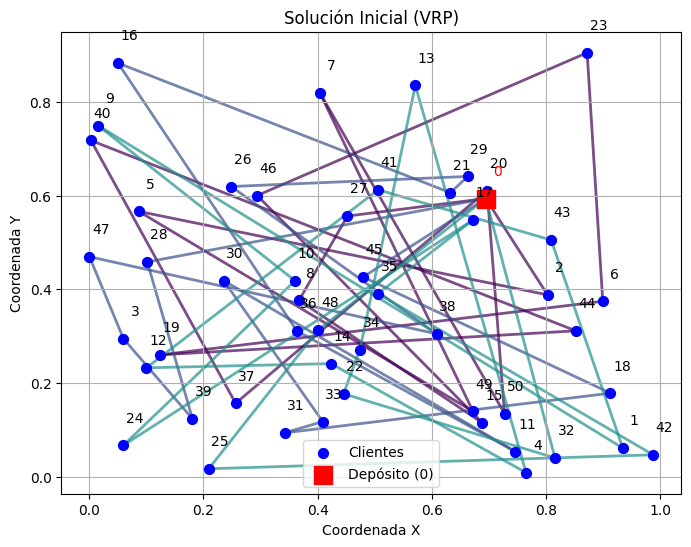


--- Ejecutando Hill Climbing ---
Solución Hill Climbing: [ 0  2  6 43 23 13  7 16  9 40  5 26 46 30  8 10 27 41 45 35 38 49 15 11
 50  0 20 29 21 28 47  3 19 12 24 25 39 37 17  0 44 18 42  1 32  4 14 48
 36 31 33 22 34  0]
Fitness Hill Climbing: 8.543176643231664
Tiempo de ejecución Hill Climbing: 3.4407 segundos


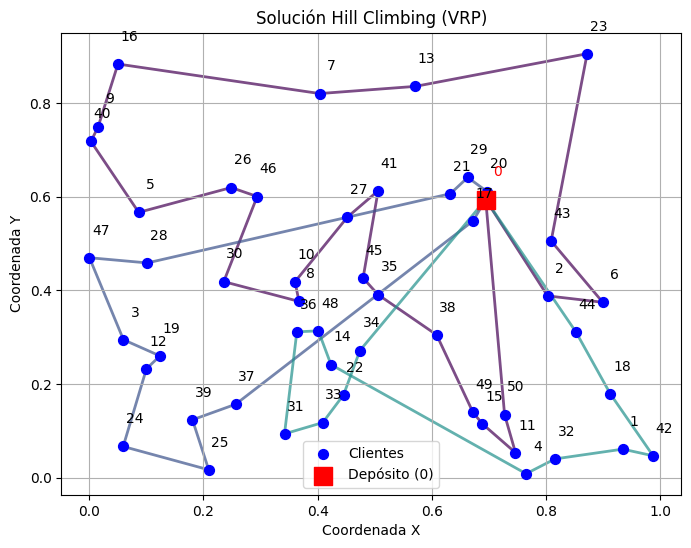


--- Ejecutando Simulated Annealing ---
Solución Simulated Annealing: [ 0 27 46 26 28 19 24 25 31 33 22 35 45 17  0 20  0 43  2 44 50 15 49 38
 34 14 48 10  8 36 37 39 12  3 47 40  9 16  5 30 11  4 32  1 42 18  6 29
 21 41  7 13 23  0]
Fitness Simulated Annealing: 7.895078125082003
Tiempo de ejecución Simulated Annealing: 29.6776 segundos


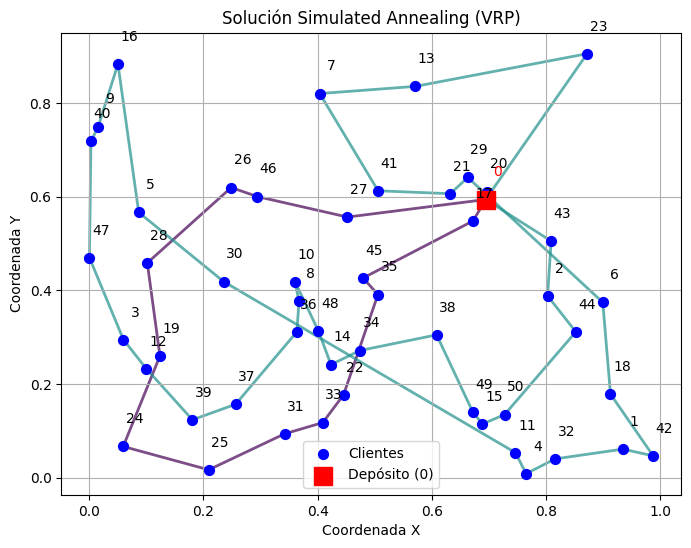

In [14]:
# Generar la solución inicial para VRP
# La solución inicial debe contener N clientes (1 a N) y N_VEHICLES + 1 depósitos (0).
# Un 0 al principio, un 0 al final, y N_VEHICLES - 1 ceros internos.
# Ejemplo: N_VEHICLES = 3, (0, C1, C2, 0, C3, C4, 0, C5, C6, 0)
clients = list(range(1, N + 1))
np.random.shuffle(clients) # Mezclar clientes

# Construir la ruta inicial asegurando los ceros en las posiciones correctas
initial_route_list = [0] # Empieza con un 0
segment_length = len(clients) // N_VEHICLES
remaining_clients = len(clients)

for i in range(N_VEHICLES):
    start_idx = i * segment_length
    end_idx = (i + 1) * segment_length

    if i == N_VEHICLES - 1: # Para el último vehículo, toma todos los clientes restantes
        initial_route_list.extend(clients[start_idx:remaining_clients])
    else:
        initial_route_list.extend(clients[start_idx:end_idx])

    if i < N_VEHICLES - 1: # Añadir un 0 intermedio si no es el último vehículo
        initial_route_list.append(0)

initial_route_list.append(0) # Termina con un 0

initial_solution = np.array(initial_route_list)


print("\n--- Solución Inicial (VRP) ---")
print("Ruta inicial:", initial_solution)
print("Fitness inicial:", fitness(initial_solution))
plot_tsp(positions, initial_solution, "Solución Inicial (VRP)")


# Parámetros para Simulated Annealing
T_max = 1000
T_min = 0.000001
cooling_rate = 0.9999

# Ejecutar Hill Climbing
print("\n--- Ejecutando Hill Climbing ---")
start_time_hc = time.time()
sol1 = hill_climbing(initial_solution)
end_time_hc = time.time()
time_hc = end_time_hc - start_time_hc

print("Solución Hill Climbing:", sol1)
fitness_hc = fitness(sol1)
print("Fitness Hill Climbing:", fitness_hc)
print("Tiempo de ejecución Hill Climbing: {:.4f} segundos".format(time_hc))
plot_tsp(positions, sol1, "Solución Hill Climbing (VRP)")

# Ejecutar Simulated Annealing
print("\n--- Ejecutando Simulated Annealing ---")
start_time_sa = time.time()
sol2 = simulated_annealing(T_max, T_min, cooling_rate, initial_solution)
end_time_sa = time.time()
time_sa = end_time_sa - start_time_sa

print("Solución Simulated Annealing:", sol2)
fitness_sa = fitness(sol2)
print("Fitness Simulated Annealing:", fitness_sa)
print("Tiempo de ejecución Simulated Annealing: {:.4f} segundos".format(time_sa))
plot_tsp(positions, sol2, "Solución Simulated Annealing (VRP)")

Resumen de Resultados

In [19]:
print("\n--- Resumen de Resultados ---")
print("Fitness Inicial:", fitness(initial_solution))
print("Hill Climbing - Fitness: {:.2f}, Tiempo: {:.4f}s".format(fitness_hc, time_hc))
print("Simulated Annealing - Fitness: {:.2f}, Tiempo: {:.4f}s".format(fitness_sa, time_sa))


--- Resumen de Resultados ---
Fitness Inicial: 4.445669344018992
Hill Climbing - Fitness: 2.55, Tiempo: 0.0025s
Simulated Annealing - Fitness: 2.55, Tiempo: 9.1322s
